 
1.495 x + 0.6605
         2
0.01604 x + 1.143 x + 1.537
          3           2
0.002642 x - 0.09374 x + 2.113 x + 0.1528


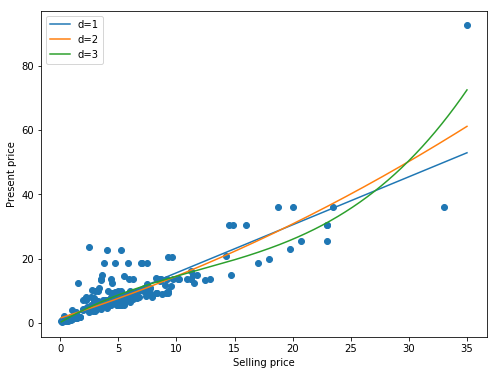

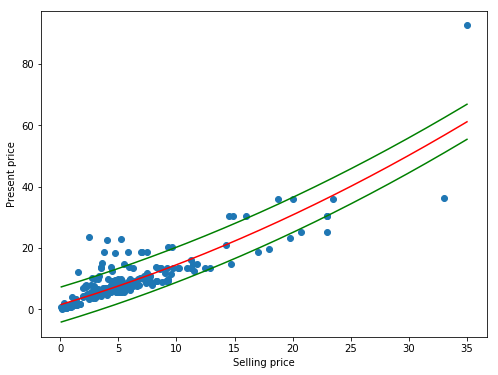

[2, 215, 78, 5, 1]


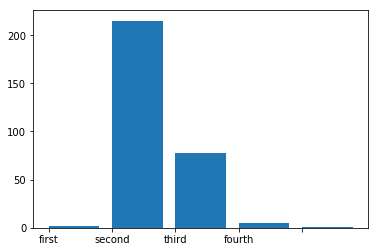

Pearson chi-square: 276.003725611266
[ 0.30718648  1.47040423 -0.01852238]
[ 0.78252036  1.43986054 -0.00651941]


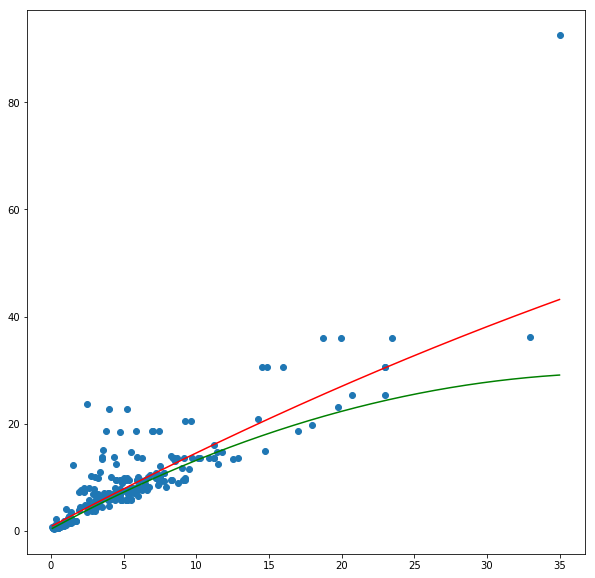

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import fsolve
from collections import Counter
import math as m
from scipy.integrate import quad
from sympy import *
from scipy.optimize import minimize



def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out


  
def lapl(x):
    left = 1/(m.sqrt(2*m.pi))
    right = quad(lambda z: m.exp((-z**2)/2), 0, x)
    return(left*right[0])



def gaussian_check(errors):
    n = len(errors) 
    #k = round(m.pow((10*n),1/3)) # определение кол-ва групп(разбиений)
    k = 5
    h = (max(errors)-min(errors))/k # ширина интервала у групп
    
    boards = [] # границы групп
    i = 0
    minb = min(errors)
    while i<=k-1:
        boards.append([minb,minb+h])
        minb+=h
        i+=1

    groups = []
    for board in boards:
        left = board[0]
        right = board[1]
        if board != boards[-1]:
            groups.append([c for c in errors if c>=left and c<right])
        else: 
            groups.append([c for c in errors if c>=left and c<=right])   
    
    hist = [len(c) for c in groups]
    print(hist)
    x = range(len(hist))
    ax = plt.gca()
    ax.bar(x, hist, align='edge') # align='edge' - выравнивание по границе, а не по центру
    ax.set_xticks(x)
    ax.set_xticklabels(('first', 'second', 'third', 'fourth'))
    plt.show()
    plt.close

    # мат ожидание и дисперсия
    mean_gr = []
    mean_gr.append([np.mean(c) for c in boards]) # середины групп   
    mean_gr = mean_gr[0] 
    mean_gr_n = [] # середины х кол-во = числитель средневзвешенного
       
    i = 0
    while i<(len(groups)):
        mean_gr_n.append(mean_gr[i]*len(groups[i]))
        i+=1

    mean = sum(mean_gr_n)/n # средневзвешенное
    
    variance = []
    variance.append([(c-mean)**2 for c in mean_gr])
    variance = variance[0]
    i=0
    while i<=len(variance)-1:
        variance[i]=variance[i]*len(groups[i])
        i+=1

    var = sum(variance)/n 
    s_sq = sum(variance)/(n-1) # Несмещенная оценка дисперсии 
    s = m.sqrt(s_sq) # Оценка среднеквадратического отклонения
       
   # Проверка гипотезы о том, что Х распределено по нормальному закону с помощью критерия согласия Пирсона.
    lapl_list = []
    p_list = []
    for board in boards:
        
        x1 = (board[0] - mean)/s
        x2 = (board[1] - mean)/s
        lapl_list.append([lapl(x1),lapl(x2)])
        p_list.append(lapl(x2)-lapl(x1))

    #print(p_list) 
    # Критерий Пирсона
    K = 0 
    i = 0    

    for i in range(len(groups)):
        K+=(len(groups[i])-n*p_list[i])**2/(n*p_list[i])
    print("Pearson chi-square:",K)


def delta_find(x,y1,y2):
    delta = 0
    accuracy = 0.9
    my_accuracy = 0
    
    while my_accuracy < accuracy :
        counter = 0    
        y_up = y1 + delta
        y_down = y1 - delta
        for i in range(len(y2)):
            if y2[i]>=y_down[i] and y2[i]<=y_up[i]:
                #print(y_up[i],'>=',y2[i],'>=',y_down[i])
                counter+=1 
        delta+=0.01       
        my_accuracy = counter/(len(y2))

    return(delta)



def Huber(l,delta):

    if m.fabs(l)<=delta:
        return 1/2*(l)**2
    else:
        return delta*m.fabs(l)-1/2*delta**2



def Tukey(l,delta): 

    if m.fabs(l)<=delta:
        return 1-(pow(1- pow(((l)/delta),2)  ,3))
    else:
        return 1



def func3(coef,X):
    return coef[0]+coef[1]*X+coef[2]*X*X




data = pd.read_csv('car_data.csv')
#print(data.head())

X = data.iloc[:,2] # selling price
y = data.iloc[:,3] # present price

plt.figure(figsize=(8, 6))
plt.xlabel("Selling price")
plt.ylabel("Present price")
plt.scatter(X, y)

legend = [] 
for i in range(1, 4):
    func = np.poly1d(np.polyfit(X, y, i, full=True)[0])
    print(func)
    x_points = np.linspace(min(X), max(X), 1000)
    plt.plot(x_points, func(x_points)) 
    legend.append("d=%i" % func.order)   

plt.legend(legend, loc="upper left")
plt.show()
plt.close()


# Выбрал 2 степень
plt.figure(figsize=(8, 6))
plt.xlabel("Selling price")
plt.ylabel("Present price")
plt.scatter(X, y)
func = np.poly1d(np.polyfit(X, y, 2, full=True)[0])
delta = delta_find(X, func(X), y) 
#delta = 1
x_points = np.linspace(min(X), max(X), 1000)
plt.plot(x_points, func(x_points),'r')
plt.plot(x_points, func(x_points)+delta,'g')
plt.plot(x_points, func(x_points)-delta,'g')
plt.show()
plt.close()


gaussian_check(y-func(X))


# Минимизация для М оценок 
start = ((func.coef).tolist())

def f(params,X,y,i):
    a, b, c = params
    return (y[i]-(a + X[i]*b + X[i]**2*c))


def f2(params): # ТЬЮКИ
    sum = 0
    for i in range(len(y)):
        if m.fabs(f(params,X,y,i))<=delta:
            sum += 1-(1-(f(params,X,y,i)/delta)**2)**3
        else: 
            sum += 1    
    return(sum)


def f3(params): # ХЬЮБЕР
    sum = 0
    for i in range(len(y)):
        if m.fabs(f(params,X,y,i))<=delta:
            sum += 0.5*(f(params,X,y,i))**2
        else: 
            sum += delta*(m.fabs(f(params,X,y,i))-0.5*delta)    
    return(sum)


initial_guess = start[::-1]
result_t = minimize(f2, initial_guess, method = 'Nelder-Mead')
result_h = minimize(f3, initial_guess, method = 'Nelder-Mead')

print(result_t.x) # Коэф-ты у минимизированной функции, когда тьюки
print(result_h.x) # Коэф-ты у минимизированной функции, когда хьюбер


# Построение М-оценок
   
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
x_points = np.linspace(min(X), max(X), 1000)
yfx = func3(result_h.x,x_points)
yfx2 = func3(result_t.x,x_points)

plt.plot(x_points, yfx,'r') 
plt.plot(x_points, yfx2, 'g')
plt.show()
plt.close()